<a href="https://colab.research.google.com/github/Van314159/RL/blob/main/MiniGrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniGrid Learned by Policy method.

2025-06-18

This notebook is a copy of [goodboychans notebook](https://colab.research.google.com/github/goodboychan/chans_jupyter/blob/main/_notebooks/2020-08-06-03-Policy-Gradient-With-Gym-MiniGrid.ipynb#scrollTo=pDJSHgvEjMY5) with updates. The original code is written in 2020 so some codes are out-of-date.

This notebook showcases basic usage of the MiniGrid environments for deep reinforcement learning (DRL) and training the agent by the policy method. It demonstrates environment setup, random and learned agent interaction, custom observation wrappers, video recording, and PyTorch-based policy training. The goal is to provide practical examples and utilities for experimenting with DRL in grid-based worlds.

In [ ]:
pip install minigrid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.7/136.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import minigrid
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

env = gym.make('MiniGrid-Empty-5x5-v0', render_mode="rgb_array")
obs, info = env.reset()
done = False

while not done:
    action = env.action_space.sample()  # take random actions
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()  # not strictly needed in human mode, but safe to include

env.close()

array([[[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [146, 146, 146],
        [146, 146, 146],
        [146, 146, 146]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [146, 146, 146],
        [146, 146, 146],
        [146, 146, 146]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [146, 146, 146],
        [146, 146, 146],
        [146, 146, 146]],

       ...,

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [146, 146, 146],
        [146, 146, 146],
        [146, 146, 146]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [146, 146, 146],
        [146, 146, 146],
        [146, 146, 146]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [146, 146, 146],
        [146, 146, 146],
        [146, 146, 146]]], dtype=uint8)
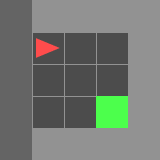

In [ ]:
env.reset()
env.render()

array([[[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       ...,

       [[146, 146, 146],
        [146, 146, 146],
        [146, 146, 146],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[146, 146, 146],
        [146, 146, 146],
        [146, 146, 146],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[146, 146, 146],
        [146, 146, 146],
        [146, 146, 146],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]]], dtype=uint8)
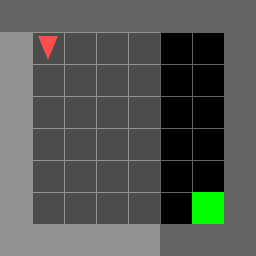

In [ ]:
env = gym.make('MiniGrid-Empty-8x8-v0', render_mode="rgb_array")
obs, _ = env.reset()
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(1)
env.render()

In [ ]:
class RandPolicy:
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, *unused_args):
        return self.action_space.sample(), None

In [ ]:
max_env_steps = 500
from gym import spaces
import numpy as np
from minigrid.core.constants import OBJECT_TO_IDX, COLOR_TO_IDX

class FlatObsWrapper(gym.ObservationWrapper):
    """
    Fully observable gridworld returning a flat grid encoding.
    Removes outer walls and encodes the grid as a flattened array.
    """

    def __init__(self, env):
        super().__init__(env)

        base_env = self.unwrapped

        # Calculate new observation space shape
        grid_h = base_env.height - 2
        grid_w = base_env.width - 2
        num_channels = 3  # object, color, direction

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(grid_h * grid_w * num_channels,),
            dtype=np.uint8
        )

        # Set max steps in the unwrapped environment
        base_env.max_steps = max_env_steps

    def observation(self, obs):
        env = self.unwrapped
        grid = env.grid.encode()  # shape: (height, width, 3)

        # Set agent info into the grid (object = agent, color = red, direction = agent_dir)
        ax, ay = env.agent_pos
        grid[ax][ay] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])

        # Remove outer walls
        cropped = grid[1:-1, 1:-1]

        # Flatten to 1D array
        flat_obs = cropped.flatten()

        return flat_obs

    def render(self, *args, **kwargs):
        """Disable highlight to remove partial view rendering."""
        #kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)


In [ ]:
env = FlatObsWrapper(gym.make('MiniGrid-Empty-8x8-v0', render_mode="rgb_array"))
obs, info = env.reset()
# Select the action right
action = 1

# Take a step in the environment and store it in appropriate variables
obs, reward, terminated, truncated, info = env.step(action)

# Render the current state of the environment
env.render()
obs

array([10,  0,  1,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        1,  0,  0,  8,  1,  0], dtype=uint8)

In [ ]:
from gymnasium.wrappers import RecordVideo

import os
from google.colab import drive
drive.mount('/content/drive')

def wrap_env(env, video_dir="/content/drive/My Drive/Videos"):
    os.makedirs(video_dir, exist_ok=True)
    env = RecordVideo(env, video_dir, episode_trigger=lambda x: True, disable_logger=True)
    return env

def gen_wrapped_env(env_name):
    raw_env = gym.make(env_name, render_mode="rgb_array")  # Important: enable render_mode
    # Original codes
    #wrapped_env = FlatObsWrapper(raw_env)
    #return wrap_env(wrapped_env)

    # by chatgpt
    raw_env = wrap_env(raw_env)       # RecordVideo FIRST
    wrapped_env = FlatObsWrapper(raw_env)                  # Then apply FlatObsWrapper
    return wrapped_env

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Random agent - we only use it in this cell for demonstration
class RandPolicy:
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, *unused_args):
        return self.action_space.sample(), None

In [ ]:
import base64
import glob
import io
from IPython.display import HTML, display
from datetime import datetime
import pytz

def show_video(video_folder='/content/drive/My Drive/Videos'):
    mp4list = glob.glob(f'{video_folder}/*.mp4')
    if len(mp4list) > 0:
        original_mp4 = max(mp4list, key=os.path.getmtime)

        # Set timezone to Tokyo
        tokyo = pytz.timezone('Asia/Tokyo')
        timestamp = datetime.now(tokyo).strftime('%Y%m%d-%H%M')
        new_filename = os.path.join(video_folder, f'{timestamp}.mp4')

        # Rename the video file if it hasn't been renamed already
        if not os.path.exists(new_filename):
            os.rename(original_mp4, new_filename)
        else:
            print(f"File {new_filename} already exists, skipping rename.")

        with open(new_filename, 'rb') as f:
            video = f.read()
        encoded = base64.b64encode(video).decode('ascii')
        display(HTML(f'''
            <video alt="test" autoplay loop controls style="height:400px;">
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>
        '''))
    else:
        print("Could not find video in", video_folder)

In [ ]:
from math import trunc
import torch

def log_policy_rollout(policy, env, pytorch_policy=False, visualize=True):
    env = gen_wrapped_env(env)
    # Initialize environment
    obs, info = env.reset()

    terminated = False
    truncated = False
    episode_reward = 0
    episode_length = 0
    done = False

    # Run until done == True
    while not done:
      # Take a step
        if pytorch_policy:
            obs_tensor = torch.tensor(obs, dtype=torch.float32)
            action = policy.act(obs_tensor)[0].cpu().numpy()
        else:
            action = policy.act(obs)[0]
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        episode_reward += reward
        episode_length += 1

    print('Total reward:', episode_reward)
    print('Total length:', episode_length)

    env.close()
    time.sleep(2)
    show_video()

In [ ]:
rand_policy = RandPolicy(FlatObsWrapper(env).action_space)

In [ ]:
test_env_name = 'MiniGrid-Empty-16x16-v0'
rand_policy = RandPolicy(FlatObsWrapper(gym.make(test_env_name)).action_space)
log_policy_rollout(rand_policy, test_env_name)

Total reward: 0
Total length: 500


In [ ]:
import gymnasium as gym
import numpy as np
import time
import minigrid # This import alone usually handles the registration


In [ ]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

class RolloutBuffer():
    def __init__(self, rollout_size, obs_size):
        self.rollout_size = rollout_size
        self.obs_size = obs_size
        self.reset()

    def insert(self, step, done, action, log_prob, reward, obs):
        self.done[step].copy_(done)
        self.actions[step].copy_(action)
        self.log_probs[step].copy_(log_prob)
        self.rewards[step].copy_(reward)
        self.obs[step].copy_(obs)

    def reset(self):
        self.done = torch.zeros(self.rollout_size, 1)
        self.returns = torch.zeros(self.rollout_size + 1, 1)
        # Assuming Discrete Action Space
        self.actions = torch.zeros(self.rollout_size, 1, dtype=torch.int64)
        self.log_probs = torch.zeros(self.rollout_size, 1)
        self.rewards = torch.zeros(self.rollout_size, 1)
        self.obs = torch.zeros(self.rollout_size, self.obs_size)

    def compute_returns(self, gamma):
        # Compute Returns until the last finished episode
        done_indices = (self.done == 1).nonzero(as_tuple=True)[0]
        self.last_done = done_indices.max() if len(done_indices) > 0 else self.rollout_size - 1
        self.returns[self.last_done + 1] = 0.

        # Accumulate discounted returns
        for step in reversed(range(self.last_done + 1)):
            self.returns[step] = self.returns[step + 1] * \
                gamma * (1 - self.done[step]) + self.rewards[step]

    def batch_sampler(self, batch_size, get_old_log_probs=False):
        sampler = BatchSampler(
            SubsetRandomSampler(range(self.last_done + 1)),
            batch_size,
            drop_last=True)
        for indices in sampler:
            if get_old_log_probs:
                yield self.actions[indices], self.returns[indices], self.obs[indices], self.log_probs[indices]
            else:
                yield self.actions[indices], self.returns[indices], self.obs[indices]

In [ ]:
import torch.nn as nn

class ActorNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super().__init__()
        self.num_actions = num_actions

        self.fc = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_actions)
        )

    def forward(self, state):
        x = self.fc(state)
        return x

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

def count_model_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class Policy():
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate,
                 batch_size, policy_epochs, entropy_coef=0.001):
        self.actor = ActorNetwork(num_inputs, num_actions, hidden_dim)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.policy_epochs = policy_epochs
        self.entropy_coef = entropy_coef

    def act(self, state):
        logits = self.actor(state)
        # To generate the probability of action, we assume its state has categorical distribution.
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob

    def evaluate_actions(self, state, action):
        logits = self.actor(state)
        dist = Categorical(logits=logits)
        log_prob = dist.log_prob(action.squeeze(-1)).view(-1, 1)
        entropy = dist.entropy().view(-1, 1)
        return log_prob, entropy

    def update(self, rollouts):
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)

            for sample in data:
                actions_batch, returns_batch, obs_batch = sample

                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)

                # Compute the mean loss for the policy update using
                # action log-probabilities and policy returns
                policy_loss = -(log_probs_batch * returns_batch).mean()
                # Compute the mean entropy for the policy update
                entropy_loss = -entropy_batch.mean()

                loss = policy_loss + self.entropy_coef * entropy_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    @property
    def num_params(self):
        return count_model_params(self.actor)


In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def plot_learning_curve(values, label='Reward', title='Training Progress'):
    import matplotlib.pyplot as plt
    plt.plot(values, label=label)
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
# Define ParamDict inline
from collections import OrderedDict

class ParamDict(OrderedDict):
    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(f"'ParamDict' object has no attribute '{name}'")
    def __setattr__(self, name, value):
        self[name] = value

    def __add__(self, other):
        return ParamDict({k: self[k] + other[k] for k in self})

    def __sub__(self, other):
        return ParamDict({k: self[k] - other[k] for k in self})

    def __mul__(self, scalar):
        return ParamDict({k: self[k] * scalar for k in self})

    def __truediv__(self, scalar):
        return ParamDict({k: self[k] / scalar for k in self})

    def copy(self):
        return ParamDict({k: v.clone() for k, v in self.items()})

In [ ]:
from IPython.display import clear_output
import time

def train(env, rollouts, policy, params, seed=123):
    # SETTING SEED: it is good practice to set seeds when running experiments to keep results comparable
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.reset(seed=seed)

    rollout_time, update_time = AverageMeter(), AverageMeter()  # Loggers
    rewards, success_rate = [], []

    print("Training model with {} parameters...".format(policy.num_params))

    # Training Loop
    for j in range(params.num_updates):
        ## Initialization
        avg_eps_reward, avg_success_rate = AverageMeter(), AverageMeter()
        done = False
        truncated = False
        terminated = False
        prev_obs, _ = env.reset()
        prev_obs = torch.tensor(prev_obs, dtype=torch.float32)
        eps_reward = 0.
        start_time = time.time()

        ## Collect rollouts
        for step in range(rollouts.rollout_size):
            if truncated or terminated:
                # Store episode statistics
                avg_eps_reward.update(eps_reward)
                if 'success' in info:
                    avg_success_rate.update(int(info['success']))

                # Reset Environment
                obs, _  = env.reset()
                obs = torch.tensor(obs, dtype=torch.float32)
                eps_reward = 0.
            else:
                obs = prev_obs

            action, log_prob = policy.act(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            rollouts.insert(step, torch.tensor(done, dtype=torch.float32), action, log_prob,
                            torch.tensor(reward, dtype=torch.float32),
                            prev_obs)

            prev_obs = torch.tensor(obs, dtype=torch.float32)
            eps_reward += reward

        # Use the rollout buffer's function to compute the returns for all stored rollout steps. (requires just 1 line)
        rollouts.compute_returns(params['discount'])

        rollout_done_time = time.time()


        # Call the policy's update function using the collected rollouts
        policy.update(rollouts)

        update_done_time = time.time()
        rollouts.reset()

        ## log metrics
        rewards.append(avg_eps_reward.avg)
        if avg_success_rate.count > 0:
            success_rate.append(avg_success_rate.avg)
        rollout_time.update(rollout_done_time - start_time)
        update_time.update(update_done_time - rollout_done_time)
        print('it {}: avgR: {:.3f} -- rollout_time: {:.3f}sec -- update_time: {:.3f}sec'.format(j,
                                                                                                avg_eps_reward.avg,
                                                                                                rollout_time.avg,
                                                                                                update_time.avg))
        if j % params.plotting_iters == 0 and j != 0:
            plot_learning_curve(rewards, success_rate, params.num_updates)
            log_policy_rollout(policy, params.env_name, pytorch_policy=True)
    clear_output()   # this removes all training outputs to keep the notebook clean, DON'T REMOVE THIS LINE!
    return rewards, success_rate

In [ ]:
import copy

def instantiate(params_in, nonwrapped_env=None):
    params = copy.deepcopy(params_in)

    if nonwrapped_env is None:
        nonwrapped_env = gym.make(params.env_name)

    env = None
    env = FlatObsWrapper(nonwrapped_env)
    obs_size = env.observation_space.shape[0]
    num_actions = env.action_space.n

    rollouts = RolloutBuffer(params.rollout_size, obs_size)
    policy_class = params.policy_params.pop('policy_class')

    policy = policy_class(obs_size, num_actions, **params.policy_params)
    return env, rollouts, policy

In [ ]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,         # number of training policy iterations
    discount = 0.999,          # discount factor
    plotting_iters = 20,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Empty-16x16-v0',  # we are using a tiny environment here for testing
)

In [ ]:
params.env_name

'MiniGrid-Empty-16x16-v0'

In [ ]:
env, rollouts, policy = instantiate(params)
env.unwrapped.max_steps
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

Training completed!


/tmp/ipython-input-31-203691428.py:17: MatplotlibDeprecationWarning: Passing label as a length 0 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(values, label=label)


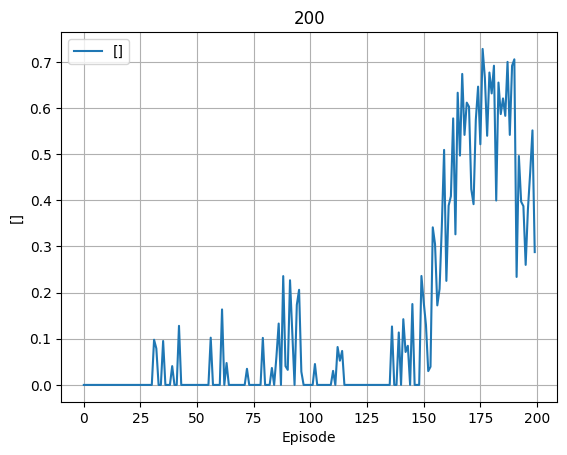

In [ ]:
# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
#for _ in range(3):
#    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

In [ ]:
log_policy_rollout(policy, params.env_name, pytorch_policy=True)

Total reward: 0.6166
Total length: 213
File /content/drive/My Drive/Videos/20250619-1441.mp4 already exists, skipping rename.
